In [1]:
# In a code cell at top of Colab
!pip install --upgrade pandas matplotlib seaborn scikit-learn scipy gdown   # optional: gdown to download from drive links



In [56]:
import pandas as pd

# Read the XLSX file
df = pd.read_excel('/content/fear_greed_index.xlsx')

#  Save as CSV
df.to_csv('sent.csv', index=False)


In [40]:
import pandas as pd

# If you uploaded files into Colab runtime:
trades = pd.read_csv('/content/historical_data - historical_data.csv')     # adjust filename
sent = pd.read_csv('/content/sent.csv', parse_dates=['date'])
sent.head()
trades.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [41]:
trades.columns


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

In [42]:
# Convert from milliseconds to datetime
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')

# Extract only the date part
trades['date_only'] = trades['Timestamp'].dt.date


In [43]:
sent['date'] = pd.to_datetime(sent['date'])
sent['date_only'] = sent['date'].dt.date


In [46]:
merged = trades.merge(
    sent[['date_only', 'classification', 'value']],
    on='date_only',
    how='left'
)

merged.head()
merged.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date_only', 'classification_x', 'value_x',
       'classification_y', 'value_y'],
      dtype='object')

In [47]:
merged.columns.tolist()


['Account',
 'Coin',
 'Execution Price',
 'Size Tokens',
 'Size USD',
 'Side',
 'Timestamp IST',
 'Start Position',
 'Direction',
 'Closed PnL',
 'Transaction Hash',
 'Order ID',
 'Crossed',
 'Fee',
 'Trade ID',
 'Timestamp',
 'date_only',
 'classification_x',
 'value_x',
 'classification_y',
 'value_y']

In [32]:
import os
os.makedirs('outputs', exist_ok=True)


In [51]:
import os
os.makedirs('csv_files', exist_ok=True)

merged.to_csv('csv_files/merged_trades_sentiment.csv', index=False)

In [52]:
!ls csv_files


merged_trades_sentiment.csv


In [53]:
summary_stats.to_csv('csv_files/summary_stats.csv', index=False)

In [57]:

import os
import pandas as pd


os.makedirs('outputs', exist_ok=True)
os.makedirs('csv_files', exist_ok=True)

# Find candidate columns that start with classification / value (case-insensitive)
cls_cols = [c for c in merged.columns if c.lower().startswith('classification')]
val_cols = [c for c in merged.columns if c.lower().startswith('value')]

# Build final columns from left-to-right non-null values among the discovered columns
if 'classification' not in merged.columns:
    if cls_cols:
        # bfill across columns to pick first non-null per row
        merged['classification'] = merged[cls_cols].bfill(axis=1).iloc[:, 0]
    else:
        # no classification columns found — create NaN column so later code fails clearly
        merged['classification'] = pd.NA

if 'value' not in merged.columns:
    if val_cols:
        merged['value'] = merged[val_cols].bfill(axis=1).iloc[:, 0]
    else:
        merged['value'] = pd.NA

# Drop the original variant columns (but keep newly created 'classification' & 'value')
cols_to_drop = [c for c in (cls_cols + val_cols) if c not in {'classification', 'value'}]
if cols_to_drop:
    merged.drop(columns=cols_to_drop, inplace=True)

#  Quick sanity: show which columns we have now and head
print("Columns after cleanup:\n", merged.columns.tolist())
print("\nclassification value counts:\n", merged['classification'].value_counts(dropna=False).head(10))
print("\nSample rows (date_only, classification, value, Closed PnL):")
display(merged[['date_only','classification','value','Closed PnL']].head(6))

#  Now compute summary_stats safely (use exact column names from your DF)
# If your numeric columns have weird types, coerce them first
merged['Closed PnL'] = pd.to_numeric(merged['Closed PnL'], errors='coerce')
merged['Size USD'] = pd.to_numeric(merged['Size USD'], errors='coerce')

summary_stats = merged.groupby('classification').agg(
    avg_profit = ('Closed PnL', 'mean'),
    median_profit = ('Closed PnL', 'median'),
    total_trades = ('Closed PnL', 'count'),
    avg_size_usd = ('Size USD', 'mean')
).reset_index()

print("\nSummary stats:")
display(summary_stats)

# Save merged and summary files (in correct order)
merged.to_csv('csv_files/merged_trades_sentiment.csv', index=False)
summary_stats.to_csv('csv_files/summary_stats.csv', index=False)

print("\nSaved files in csv_files/:")
!ls -l csv_files



/tmp/ipython-input-390855563.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['classification'] = merged[cls_cols].bfill(axis=1).iloc[:, 0]


Columns after cleanup:
 ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'date_only', 'classification', 'value']

classification value counts:
 classification
Fear             133871
Greed             36289
NaN               26961
Neutral            7141
Extreme Greed      6962
Name: count, dtype: int64

Sample rows (date_only, classification, value, Closed PnL):


,date_only,classification,value,Closed PnL
0,2024-10-27,Greed,74.0,0.0
1,2024-10-27,Greed,74.0,0.0
2,2024-10-27,Greed,74.0,0.0
3,2024-10-27,Greed,74.0,0.0
4,2024-10-27,Greed,74.0,0.0
5,2024-10-27,Greed,74.0,0.0



Summary stats:


,classification,avg_profit,median_profit,total_trades,avg_size_usd
0,Extreme Greed,25.418772,0.0,6962,5660.265764
1,Fear,50.047622,0.0,133871,5259.977837
2,Greed,87.894859,0.0,36289,3182.883845
3,Neutral,22.229713,0.0,7141,3058.848110



Saved files in csv_files/:
total 55004
-rw-r--r-- 1 root root 56319425 Aug  8 08:56 merged_trades_sentiment.csv
-rw-r--r-- 1 root root      285 Aug  8 08:56 summary_stats.csv


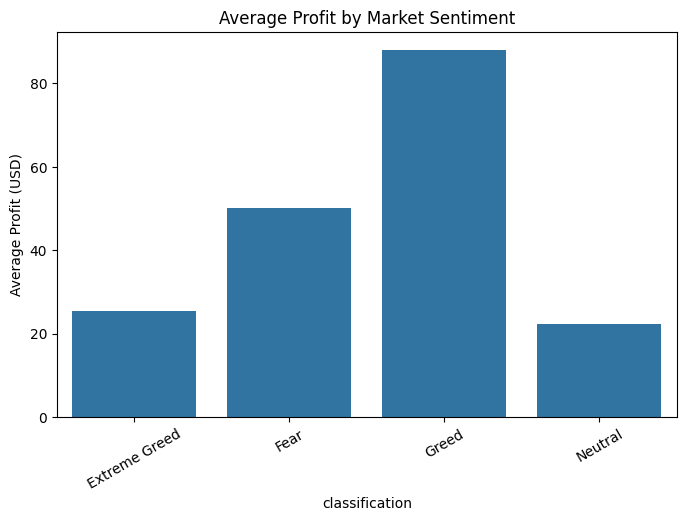

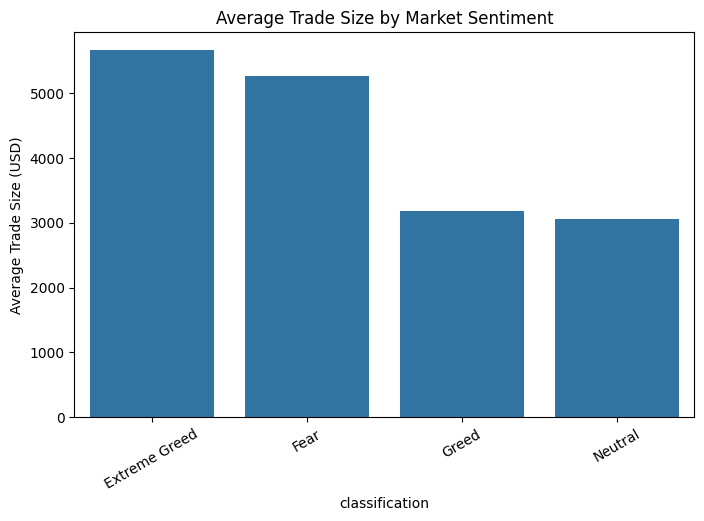

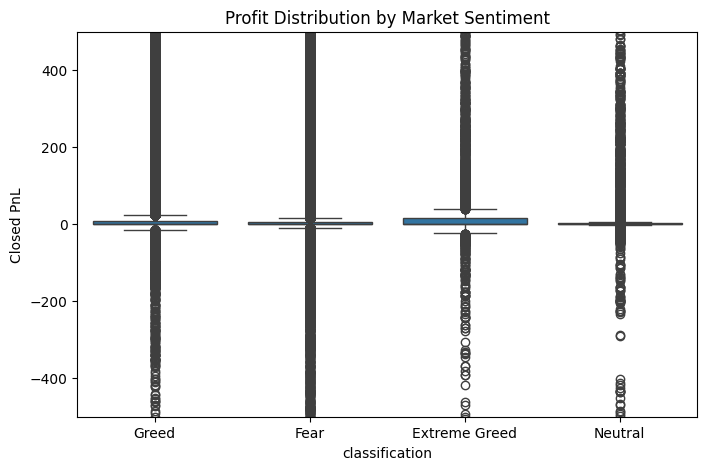

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart: avg profit by classification
plt.figure(figsize=(8,5))
sns.barplot(x='classification', y='avg_profit', data=summary_stats)
plt.title('Average Profit by Market Sentiment')
plt.ylabel('Average Profit (USD)')
plt.xticks(rotation=30)
plt.savefig('outputs/avg_profit_by_sentiment.png', bbox_inches='tight')
plt.show()

# Bar chart: avg trade size by classification
plt.figure(figsize=(8,5))
sns.barplot(x='classification', y='avg_size_usd', data=summary_stats)
plt.title('Average Trade Size by Market Sentiment')
plt.ylabel('Average Trade Size (USD)')
plt.xticks(rotation=30)
plt.savefig('outputs/avg_size_by_sentiment.png', bbox_inches='tight')
plt.show()

# Boxplot: Closed PnL by classification (per trade)
plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='Closed PnL', data=trades)
plt.ylim(-500, 500)  # zoom in to remove extreme outliers
plt.title('Profit Distribution by Market Sentiment')
plt.savefig('outputs/profit_distribution_by_sentiment.png', bbox_inches='tight')
plt.show()


In [36]:
#Testing if differences in average profit are statistically significant between classifications (e.g., Fear vs Greed):


from scipy.stats import mannwhitneyu

fear_profits = trades.loc[trades['classification']=='Fear', 'Closed PnL']
greed_profits = trades.loc[trades['classification']=='Greed', 'Closed PnL']

stat, p = mannwhitneyu(fear_profits, greed_profits, alternative='two-sided')
print(f"U-statistic: {stat}, p-value: {p}")


U-statistic: 2348137008.5, p-value: 1.350798471586583e-25


Correlation: nan, p-value: nan


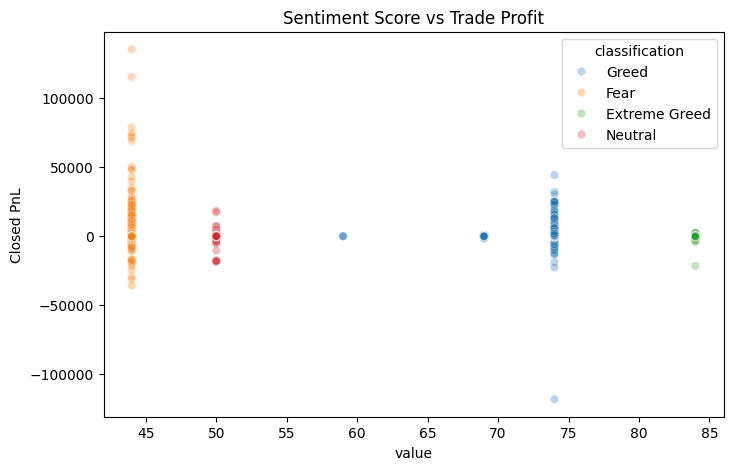

In [60]:
#Checks correlation between numeric sentiment score and trade profit:



from scipy.stats import pearsonr

corr, pval = pearsonr(trades['value'], trades['Closed PnL'])
print(f"Correlation: {corr:.3f}, p-value: {pval:.4f}")

plt.figure(figsize=(8,5))
sns.scatterplot(x='value', y='Closed PnL', hue='classification', data=trades, alpha=0.3)
plt.title('Sentiment Score vs Trade Profit')
plt.savefig('outputs/value_vs_profit.png', bbox_inches='tight')
plt.show()


In [61]:
# Drop NaNs before computing correlation
corr_df = trades[['value', 'Closed PnL']].dropna()

corr, pval = pearsonr(corr_df['value'], corr_df['Closed PnL'])
print(f"Correlation: {corr:.3f}, p-value: {pval:.4f}")


Correlation: 0.011, p-value: 0.0000
